In [1]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Creating a Point Cloud from Sample data

The below cells load an RGB image and Depth map that we prepared earlier in order to test projection and unprojection code.

The depth map is normalized to the range (0, 1), and is best visualized with a logarithmic plot.

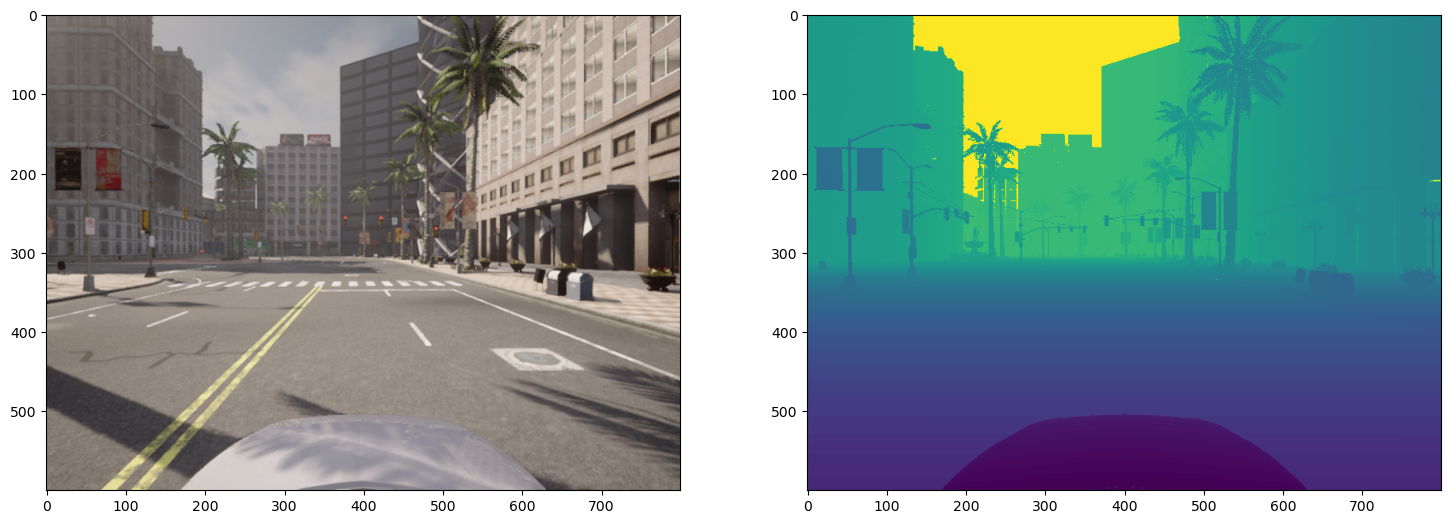

In [2]:
data = np.load('data.npz')
rgb, depth, K = data['rgb'], data['depth'], data['K']

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(18, 10))
ax0.imshow(rgb)
ax1.imshow(np.log(depth))
plt.show()

## Generate a point cloud

We can generate a local point cloud from these images by adapting the image converter code here:

https://github.com/melfm/carla/blob/d80e1c91747e5778195f21e58c20d22c26ca0873/PythonClient/carla/image_converter.py

The trickiest part of this conversion is that the $u, v$ coordinates need to be generated from top to bottom, left to right.
I have extracted a function that does this explicitly to illustrate.

In [2]:
def uv_coords(height, width):
    # Generate pixel coordinates in Carla's reference frame.
    u = np.tile(np.flip(np.arange(0, width)), height)
    v = np.repeat(np.flip(np.arange(0, height)), width)
    return u, v


def local_point_cloud(rgb, depth, K, max_depth=0.9):
    far = 1000.0  # max depth in meters.
    height, width = depth.shape
    
    # Generate a map of image indices to 2d pixel coordinates.
    pixels = height * width
    u_coord, v_coord = uv_coords(height, width)
    
    # Create color and depth points.
    colors = rgb.reshape(pixels, 3)
    depths = depth.reshape(pixels)
    
    # Create an index of pixels where depth is lte max_depth.
    indices = np.where(depths <= max_depth)

    # Create homogeneous coordinates
    points = np.array([u_coord, v_coord, np.ones_like(u_coord)])

    # Unproject to camera coordinates.
    points  = np.linalg.inv(K) @ points
    points *= depths * far
    points  = points.T

    return points[indices], colors[indices] / 255.

In [3]:
points, colors = local_point_cloud(rgb, depth, K)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(colors)
o3d.io.write_point_cloud("data.ply", pcd)

NameError: name 'rgb' is not defined

# Generating Data with Carla

We need to create a *synchronous* client to ensure that we receive data from the RGB camera and Depth camera *simultaneously*.

https://carla.readthedocs.io/en/latest/adv_synchrony_timestep/#client-server-synchrony

Also, ignoring traffic lights will let you collect more meaningful data faster. Whee!

In [3]:
import carla
import queue

In [4]:
# Connect the client
client = carla.Client('localhost', 2000) 

# Reset the world and obliterate all settings
client.reload_world()

# Get world, blueprints and spawn points
world = client.get_world()
blueprint = world.get_blueprint_library()
spawn_points = world.get_map().get_spawn_points()

In [5]:
# Add the ego vehicle
vehicle_bp = blueprint.find('vehicle.lincoln.mkz_2020') 
vehicle = world.try_spawn_actor(vehicle_bp, spawn_points[72])

# Set initial camera translation
camera_init_trans = carla.Transform(carla.Location(z=2))

# Add one of each type of camera
rgb_camera_bp = blueprint.find('sensor.camera.rgb') 
rgb_camera = world.spawn_actor(rgb_camera_bp, camera_init_trans, attach_to=vehicle)

depth_camera_bp = blueprint.find('sensor.camera.depth') 
depth_camera = world.spawn_actor(depth_camera_bp, camera_init_trans, attach_to=vehicle)

In [6]:
# Move to the car
spectator = world.get_spectator() 
spectator.set_transform(rgb_camera.get_transform())

In [7]:
# Create a queue to buffer the data
rgb_queue = queue.Queue()
depth_queue = queue.Queue()
extrinsics_queue = queue.Queue()

In [34]:
# Before recording any sensor data, we configure our world to be synchronized with a fixed time step.
# Otherwise, our sensors will not be aligned!
world_settings = world.get_settings()
world_settings.synchronous_mode = True
world_settings.fixed_delta_seconds = 5
world.apply_settings(world_settings)


# Set sensors recording
rgb_camera.listen(lambda image: rgb_queue.put((image, rgb_camera.get_transform())))
depth_camera.listen(lambda image: depth_queue.put((image, depth_camera.get_transform())))
extrinsics_queue.put(rgb_camera.get_transform().get_inverse_matrix())
# extrinsics are relative to global coordinates

# Configure driving behaviour and start driving around
traffic_manager = client.get_trafficmanager()
traffic_manager.ignore_lights_percentage(vehicle, 100)
vehicle.set_autopilot(True)

Each run of the below cell will add an RGB image and a Depth image to the queue, accumulating a dataset.

In [55]:
# Advance our world state and move the spectator camera to the vehicle.
# Run this cell as many times as you like.
# for i in range (0, 10):
world.tick()
rgb_camera_pose = rgb_camera.get_transform()
spectator.set_transform(rgb_camera_pose)

In [56]:
# Create our datasets and stop the cameras.
rgb_dataset = list(rgb_queue.queue)
depth_dataset = list(depth_queue.queue)
extrinsics_dataset = list(extrinsics_queue.queue)
# rgb_camera.stop()
# depth_camera.stop()

In [57]:
len(rgb_dataset)

48

In [15]:
rgb_dataset[5]

(<carla.libcarla.Image at 0x1f74d2f95f0>,
 <carla.libcarla.Transform at 0x1f74d2f9660>)

# Save a Single Frame

You will need to adapt this code to save multiple frames.

In [60]:
def get_intrinsic_matrix(camera):
    image_w = int(camera.attributes['image_size_x'])
    image_h = int(camera.attributes['image_size_y'])
    fov     = float(camera.attributes["fov"])
    focal   = image_w / (2.0 * np.tan(fov * np.pi / 360.0))

    # In this case Fx and Fy are the same since the pixel aspect ratio is 1
    K = np.identity(3)
    K[0, 0] = K[1, 1] = focal
    K[0, 2] = image_w / 2.0
    K[1, 2] = image_h / 2.0
    return K



def carla_image_to_bgra(image):
    channels = np.frombuffer(image.raw_data, dtype=np.dtype("uint8"))
    return channels.reshape(image.height, image.width, 4)


def carla_image_to_rgb(image):
    channels = carla_image_to_bgra(image)
    return channels[..., [2, 1, 0]]/255


def carla_image_to_depth(image):
    channels = carla_image_to_bgra(image)
    # Promote to floating point, arbitrary precision
    channels = channels * 1.0

    B = channels[..., 0]
    G = channels[..., 1]
    R = channels[..., 2]

    return (R + G * 256 + B * 256 * 256) / (256 * 256 * 256 - 1)

In [67]:
rgb_image1,rgbpose1 = rgb_dataset[0]
depth_image1,depthpose1 = depth_dataset[0]
rgb_image2,rgbpose2 = rgb_dataset[20]
depth_image2,depthpose2 = depth_dataset[20]

In [68]:
import matplotlib.pyplot as plt

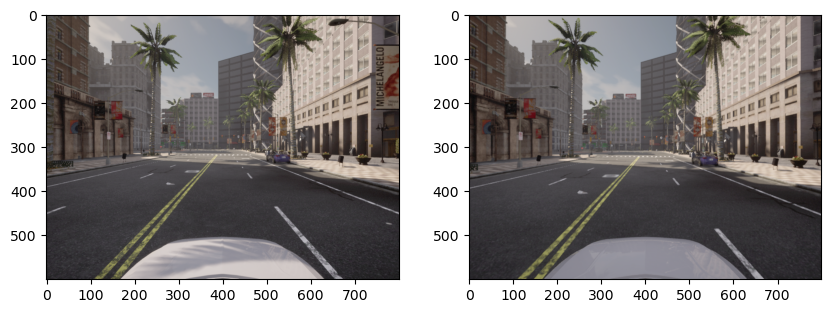

In [69]:
fig,ax = plt.subplots(1, 2,figsize=(10,5))
ax[0].imshow(carla_image_to_rgb(rgb_image1))
ax[1].imshow(carla_image_to_rgb(rgb_image2))

In [20]:
K = get_intrinsic_matrix(rgb_camera)
type(K)

numpy.ndarray

In [50]:
rgb_dataset[10]

(<carla.libcarla.Image at 0x27090a0e200>,
 <carla.libcarla.Transform at 0x27090a0e190>)

In [70]:
K = get_intrinsic_matrix(rgb_camera)
rgb_image, rgb_pose = rgb_dataset[0]
depth_image, depth_pose = depth_dataset[0]
rgb_image2, rgb_pose2 = rgb_dataset[20]
depth_image2, depth_pose2 = depth_dataset[20]
rgb_image_3, rgb_pose_3 = rgb_dataset[10]
depth_image_3, depth_pose_3 = depth_dataset[10]

rgb = carla_image_to_rgb(rgb_image)
depth = carla_image_to_depth(depth_image)
extrinsic1 = rgb_pose.get_inverse_matrix()
rgb2 = carla_image_to_rgb(rgb_image2)
depth2 = carla_image_to_depth(depth_image2)
extrinsic2 = rgb_pose2.get_inverse_matrix()

rgb3 = carla_image_to_rgb(rgb_image_3)
depth3 = carla_image_to_depth(depth_image_3)
extrinsic3 = rgb_pose_3.get_inverse_matrix()
# np.savez_compressed('data.npz', rgb=rgb, depth=depth, K=K,extrinsic = extrinsic1)
# np.savez_compressed('data2.npz', rgb=rgb2, depth=depth2, K=K,extrinsic = extrinsic2)
# np.savez_compressed('data3.npz', rgb=rgb3, depth=depth3, K=K,extrinsic = extrinsic3)

np.savez_compressed('data_triplet_2.npz', rgb1=rgb, depth1=depth, K=K,extrinsic1 = extrinsic1,
                    rgb2=rgb2, depth2=depth2, extrinsic2 = extrinsic2,
                    rgbq=rgb3, depthq=depth3, extrinsicq = extrinsic3)

: 

In [ ]:
K

In [109]:
extrinsics_queue.get(10)

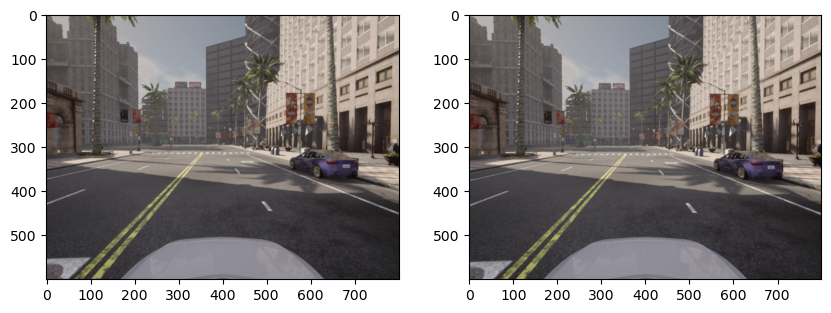

In [61]:
fig, ax = plt.subplots(1, 2,figsize = (10,10))
ax[0].imshow((rgb))
ax[1].imshow((rgb2))